<a href="https://colab.research.google.com/github/MaxW-M/FragmentForest/blob/main/Fragment_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports

import numpy as np
from sklearn import tree
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [ ]:
input_data = ['1-octanol', 'butyl acetate', 'chloroform', 'cyclohexane', 'dichloromethane',
              'triolein', 'n-hexane', 'n-octane', 'oleylalcohol', 'toluene', 'n-undecane',
              'MONOISOTOPIC_MASS', 'H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'I', 'Br',
              'benzene','Al_COO','Al_OH','Al_OH_noTert', 'ArN','Ar_COO','Ar_N',
              'Ar_NH', 'Ar_OH', 'COO', 'COO2', 'C_O', 'C_O_noCOO', 'C_S', 'HOCCN',
              'Imine', 'NH0', 'NH1', 'NH2', 'N_O', 'Ndealkylation1', 'Ndealkylation2',
              'Nhpyrrole', 'SH', 'aldehyde', 'alkyl_carbamate', 'alkyl_halide',
              'allylic_oxid', 'amide', 'amidine', 'aniline', 'aryl_methyl', 'azide',
              'azide', 'azo', 'barbitur', 'benzodiazepine', 'bicyclic', 'diazo',
              'dihydropyridine', 'epoxide', 'ester', 'ether', 'furan', 'guanido',
              'halogen', 'hdrzine', 'hdrzone', 'imidazole', 'imide', 'isocyan',
              'isothiocyan', 'ketone', 'ketone_Topliss', 'lactam', 'lactone',
              'methoxy', 'morpholine', 'nitrile', 'nitro_arom', 'nitro_arom_nonortho',
              'nitroso', 'oxazole', 'oxime', 'para_hydroxylation', 'phenol',
              'phenol_noOrthoHbond', 'phos_acid', 'phos_ester', 'piperdine', 'piperzine',
              'priamide', 'prisulfonamd', 'pyridine', 'quatN', 'sulfide', 'sulfonamd',
              'sulfone', 'term_acetylene', 'tetrazole', 'thiazole', 'thiocyan',
              'thiophene', 'unbrch_alkane', 'urea']

target_data = ['Al_COO','Al_OH','Al_OH_noTert', 'ArN','Ar_COO','Ar_N', 'benzene',
                 'Ar_NH', 'Ar_OH', 'COO', 'COO2', 'C_O', 'C_O_noCOO', 'C_S', 'HOCCN',
                 'Imine', 'NH0', 'NH1', 'NH2', 'N_O', 'Ndealkylation1', 'Ndealkylation2',
                 'Nhpyrrole', 'SH', 'aldehyde', 'alkyl_carbamate', 'alkyl_halide',
                 'allylic_oxid', 'amide', 'amidine', 'aniline', 'aryl_methyl', 'azide',
                 'azide', 'azo', 'barbitur', 'benzodiazepine', 'bicyclic', 'diazo',
                 'dihydropyridine', 'epoxide', 'ester', 'ether', 'furan', 'guanido',
                 'halogen', 'hdrzine', 'hdrzone', 'imidazole', 'imide', 'isocyan',
                 'isothiocyan', 'ketone', 'ketone_Topliss', 'lactam', 'lactone',
                 'methoxy', 'morpholine', 'nitrile', 'nitro_arom', 'nitro_arom_nonortho',
                 'nitroso', 'oxazole', 'oxime', 'para_hydroxylation', 'phenol',
                 'phenol_noOrthoHbond', 'phos_acid', 'phos_ester', 'piperdine', 'piperzine',
                 'priamide', 'prisulfonamd', 'pyridine', 'quatN', 'sulfide', 'sulfonamd',
                 'sulfone', 'term_acetylene', 'tetrazole', 'thiazole', 'thiocyan',
                 'thiophene', 'unbrch_alkane', 'urea']

'''
preconditions: x is a numpy array of data
               test_size is the percentage of data to be witheld for testing
postconditions: returns a random list of ones and zeros that indicate which data points
                should be used for testing and which data points should be used for training
'''
def test_train_split(x, test_size=0.1):

    idx = np.random.choice(np.arange(len(x)), size=int(len(x) * test_size), replace=False)
    mask = np.ones(len(x)).astype('bool')
    mask[idx] = False

    return mask

'''
preconditions: data is the path to the data file
               output is the path to the file where the trimmed csv will be saved
               set shuffle to True if you want the data shuffled
postconditions: returns input and output data as x and y respectively
'''
def process_data(data, output, shuffle=False):
    # read csv file with the data
    df = pd.read_csv(data)

    # remove any non-input or SMILES columns
    for col in df.columns:
      if col not in input_data:
        df.drop(columns=col, inplace=True)

    # shuffle the data
    if shuffle:
      df = df.sample(frac=1).reset_index(drop=True)

    # save the trimmed data frame
    df.to_csv(output, index=False)

    # split the dataframe into x and y values
    y_df = df
    y_df = y_df[target_data]
    df.drop(columns=target_data, inplace=True)

    # turn x and y into numpy arrays
    x = df.to_numpy()
    y = y_df.to_numpy()

    mask = test_train_split(x, test_size=0.2)
    x_train = x[mask]
    y_train = y[mask]
    x_test = x[~mask]
    y_test = y[~mask]

    return x_train, y_train, x_test, y_test

In [ ]:
# @title Random Forest

def build_random_forest(features, targets, x_test, output, num_trees=100):
  '''
  Train a Random Forest with bootstrapped samples, using Gini Impurtity to evaluate each split.
  Outputs the Out-Of-Bag Error (OOB Error)

  By default it build a Random Forest with 100 treees and randomly picks sqrt(number of features) at each
  split.

  param features: model features
  param targets: model targets
  '''

  # oob_score parameter means the model will use out-of-bag samples to estimate generalization score.
  # to get oob_score, the model requires bootsrap aparameter to be True
  random_forest = RandomForestRegressor(n_estimators=num_trees, random_state=0)
  random_forest.fit(features, targets)
  pickle.dump(random_forest, open(output, 'wb'))

  y_pred = random_forest.predict(x_test).flatten()

  '''
  print('Mean Absolute Error:', metrics.mean_absolute_error(targets, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(targets, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(targets, y_pred)))
  print('R Squared Error: ', metrics.r2_score(targets, y_pred))
  '''

  return y_pred

In [ ]:
def r_squared_error_viz(features, targets, number_trees):
  '''
  Visualize the r squared Error as a function of the number of trees in the Random Forest.

  param features: model features
  param targets: model targets
  param number_trees: maximum size of the random forest
  '''

  # range is exclusive, it stops at N+1
  # starts with 5 trees, otherwise its too few for the algorithm to run
  min_number_trees = 5
  max_depth_array = range(min_number_trees, number_trees+1)
  r_squared_error_array = []

  for tree_i in max_depth_array:
    # show progress on computation
    if tree_i % 25 == 0:
      print("Building Random Forest with " + str(tree_i) + " trees")

    # Out-Of-Bag Error
    r_squared_error_array.append(np.round(build_random_forest(features, targets, 'model.h5', num_trees=tree_i), 2))

  # outputs the lowest OOB error and the OOB error for the biggest random forest built.
  highest_r_error = max(r_squared_error_array)
  best_forest_size = r_squared_error_array.index(highest_r_error) + min_number_trees
  print("\nRandom Forest with " + str(best_forest_size) + " trees, has r Squared Error = " + str(highest_r_error))

  fig, ax = plt.subplots(figsize=(17, 12))

  # removing all borders except bottom
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  # setting y-axis limit to range to be from 0 to 1
  plt.ylim([0, 1])
  ax.plot(max_depth_array, r_squared_error_array, color='#435373', linewidth=3)

  # setting plot title and naming axis
  plt.title("Out-Of-Bag Error as a function of number of trees\n in Random Forest", fontsize=25)
  ax.set_xlabel("Number of trees in Random Forest", fontsize=18, labelpad=15)
  ax.set_ylabel("OOB Error", fontsize=18, labelpad=15)

  plt.show()


In [ ]:
def plot_trueVSpred(ytrue, y_pred):
    fig = plt.figure()
    plt.scatter(ytrue, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()
    return(fig)



def plot_error(ytrue, y_pred):
    fig = plt.figure()
    error = y_pred - ytrue
    plt.hist(error, bins = 10)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.show()
    return(fig)

[0.         0.         0.         ... 0.         0.         0.02631579]


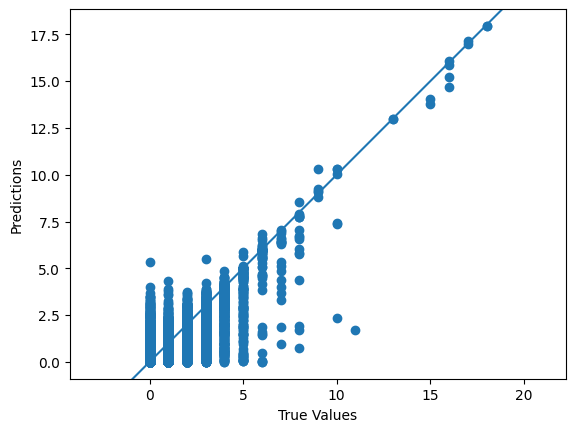

In [ ]:
features, targets, x_test, y_test = process_data('drive/MyDrive/Data Sets/TurboChemDB5.2.csv', 'processed_data.npy')
# ideal number of trees = 38
y_pred = build_random_forest(features, targets, x_test, 'model.h5', num_trees=38)
print(y_pred)
fig = plot_trueVSpred(y_test, y_pred)

In [ ]:
# Export data into a dataframe
y_pred = np.reshape(y_pred, (y_test.shape[0], 85))
print(y_pred.shape)
df = pd.DataFrame(y_pred)
df.to_csv('Fragment_Forest_Predicted.csv') # Print data to a csv file

R2 = np.round(metrics.r2_score(y_test, y_pred), 2)
mae = np.round(metrics.mean_absolute_error(y_test, y_pred), 2)

print("Training set R2 = " + str(R2))
print("Training set Mean Abs Error = " + str(mae))

(6484, 85)
Training set R2 = 0.33
Training set Mean Abs Error = 0.07


In [ ]:
print(y_pred)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05263158 0.         0.        ]
 [0.05263158 0.05263158 0.02631579 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02631579 0.         0.15789474]
 [0.         0.31578947 0.10526316 ... 0.         0.         0.02631579]]


In [ ]:
ff_reg_predicted = pd.DataFrame(y_pred)
ff_reg_predicted = ff_reg_predicted.round()

actual = pd.DataFrame(data = y_test)



In [ ]:
predicted_totals = np.ndarray(84)
actual_totals = np.ndarray(84)
fragment_error = np.ndarray(84)

for i in range(ff_reg_predicted.columns.size - 1):
    predicted_totals[i] = np.sum(ff_reg_predicted.iloc[:,i])
    actual_totals[i] = np.sum(actual.iloc[:,i])
    if actual_totals[i] != 0:
        fragment_error[i] = np.abs(predicted_totals[i] - actual_totals[i])/actual_totals[i]
    else:
        fragment_error[i] = predicted_totals[i]

fragment_error_df = pd.DataFrame(fragment_error)
fragment_error_df.style

,0
0,0.259470
1,0.299435
2,0.807018
3,0.424318
4,0.391566
5,0.003381
6,0.011294
7,0.504323
8,0.255601
9,0.111628


0.2624618840802011
0.41013011815935935


(array([4.014e+03, 1.771e+03, 4.860e+02, 1.300e+02, 1.100e+01, 1.800e+01,
        2.000e+00, 1.600e+01, 0.000e+00, 1.000e+00, 0.000e+00, 8.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.200e+01, 0.000e+00, 0.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0.        , 0.26666667, 0.53333333, 0.8       , 1.06666667,
        1.33333333, 1.6       , 1.86666667, 2.13333333, 2.4       ,
        2.66666667, 2.93333333, 3.2       , 3.46666667, 3.73333333,
        4.        , 4.26666667, 4.53333333, 4.8       , 5.06666667,
        5.33333333, 5.6       , 5.86666667, 6.13333333, 6.4       ,
        6.66666667, 6.93333333, 7.2       , 7.46666667, 7.73333333,
        8.        ]),
 <BarContainer object of 30 artists>)

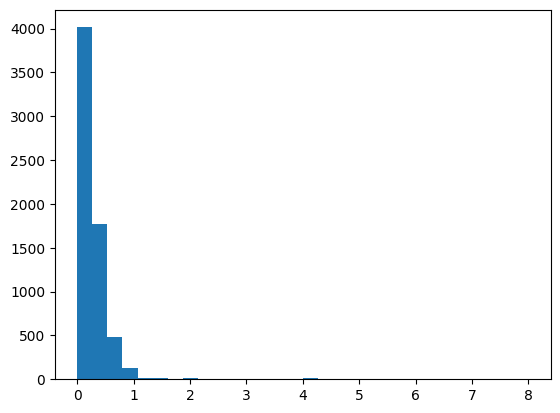

In [ ]:
numRows = ff_reg_predicted.shape[0]

predicted_row_totals = np.ndarray(numRows)
actual_row_totals = np.ndarray(numRows)
molecule_error = np.ndarray(numRows)

for i, row in ff_reg_predicted.iterrows():
    predicted_row_totals[i] = np.sum(ff_reg_predicted.iloc[i,:])
    actual_row_totals[i] = np.sum(actual.iloc[i,:])
    if actual_row_totals[i] != 0:
        molecule_error[i] = np.abs(predicted_row_totals[i] - actual_row_totals[i])/actual_row_totals[i]
    else:
        molecule_error[i] = predicted_row_totals[i]

total_molecule_error = np.sum(molecule_error)/numRows
print(total_molecule_error)
sd = np.std(molecule_error)
print(sd)
plt.hist(molecule_error, bins=30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
